# Predicting Exciting K12 School Projects

# Summary

At any given time, teachers of K12 schools across the US post projects of their students and donors can donate to them through DonorsChoose.org, a Charity organization that helps students in need of funding for projects. They help students with project resources once a project reaches its funding goal (**fully_funded**). The 2014 KDD Cup is about helping DonorsChoose to find projects that are especially exciting at the time they get posted, for donors to make donations. 

A note to the reader - I used a R kernel because I've been using more R recently at my current position and because this is a timed assignment, I am just going ahead with it. However, I can reproduce this in python (given a bit more time)

## Setting Up Packages

In [30]:
#Getting the packages - This might take a while depending on what packages are available in your r installation
country.code <- 'us'  
url.pattern <- 'https://'  
repo.data.frame <- subset(getCRANmirrors(), CountryCode == country.code & grepl(url.pattern, URL))
options(repos = repo.data.frame$URL)
list.of.packages <- c("ggplot2", "dplyr","data.table","maps","Amelia","ROCR")
new.packages <- list.of.packages[!(list.of.packages %in% installed.packages()[,"Package"])]
if(length(new.packages)>0) install.packages(new.packages)

In [32]:
library(dplyr)
library(data.table)
library(ggplot2)
library(maps)
library(Amelia)
require(ROCR)

In [36]:
# user defined functions needed

#Convert NAs and INFs to 0
naan <- function(x) return(ifelse(is.na(x) | is.nan(x)|is.infinite(x),0,x))

#gains chart
gain.chart <- function(n,predict,act) {
  a <- order(-predict)
  b <- predict[a]
  c <- act[a]
  n1 <- ceiling(length(b)/n)
  nr <- length(b)
  sp<- split(b, rep(1:ceiling(nr/n1), each=n1, length.out=nr))
  spa <- split(c, rep(1:ceiling(nr/n1), each=n1, length.out=nr))
  d <- c()
  for(i in 1:length(sp)) d <- c(d,length(which(spa[[i]]==1))/length(sp[[i]]))
  barplot(d,main='gains chart',axisnames = T,names.arg = c(1:n))
}

#ROC Curve
plo <- function(predicted,act)
{
  pred = prediction(predicted, act)
  roc = performance(pred, "tpr", "fpr")
  auc = performance(pred, "auc")
  auc = unlist(auc@y.values)
  print(auc)
  plot(roc, lwd=2, colorize=TRUE,main=paste('ROC Curve','Area under ROC = ',round(auc,2)))
  lines(x=c(0, 1), y=c(0, 1), col="black", lwd=1)
  mtext('Threshold for Reactivation',side=4,srt=90)
}    


## Let's get the data in

In [8]:
donations <- read.csv(file.choose(),sep=',',dec='.',stringsAsFactors = F)
essays <- read.csv(file.choose(),sep=',',dec='.',stringsAsFactors = F)
outcomes <- read.csv(file.choose(),sep=',',dec='.',stringsAsFactors = F)
projects <- read.csv(file.choose(),sep=',',dec='.',stringsAsFactors = F)
resources <- read.csv(file.choose(),sep=',',dec='.',stringsAsFactors = F)
sample_test <- read.csv(file.choose(),sep=',',dec='.',stringsAsFactors = F)

Warning message in scan(file = file, what = what, sep = sep, quote = quote, dec = dec, :
"EOF within quoted string"

## Some initial data processing

In [9]:

projects[,names(outcomes)[2:ncol(outcomes)]] <- outcomes[match(projects$projectid,outcomes$projectid),names(outcomes)[2:ncol(outcomes)]]
projects$date_posted <- as.Date(projects$date_posted,"%Y-%m-%d")
projects$calper <- as.numeric(paste(as.character(year(projects$date_posted)),sprintf("%03d",as.numeric(month(projects$date_posted))),sep=""))
projects$train <- ifelse(projects$projectid %in% outcomes$projectid,1,0)
projects$school_state[projects$school_state=='La'] <- 'LA'

## More data processing for initial visualizations - getting an initial assessment

In [33]:
a <- projects[projects$train==1,] %>% group_by(school_state) %>% summarise(n=n(),is_exciting=length(which(is_exciting=='t')))
a$pex <- a$is_exciting*100/a$n
a$donations <- sapply(a$school_state,function(x) sum(donations$donation_total[which(donations$projectid %in% projects$projectid[projects$school_state==x])],na.rm=T))
a$donationsperproj <- a$donations / a$n
a$samestatedonation <- sapply(a$school_state,function(x) sum(donations$donation_total[which(donations$projectid %in% projects$projectid[projects$school_state==x] & donations$donor_state==x)],na.rm=T))
a$samestatedonationp <- a$samestatedonation / a$donations
a$ndonor <- sapply(a$school_state,function(x) length(unique(donations$donor_acctid[which(donations$donor_state==x)])))
a$donationperdonor <- a$donations / a$ndonor
mapd <- map_data("state")
statenames <- as.data.frame(setNames(state.abb, state.name),stringsAsFactors = F)
names(statenames) <- 'school_state'
statenames$statename <- tolower(rownames(statenames))
statenames['district of columbia',] <- c('DC','district of columbia')
a$statename <- statenames$statename[match(a$school_state,statenames$school_state)]
mapd[,c('No. of Applicants','% Exciting','Donations Per Project',
        'Same State Donations %','Donations per Donor')] <- a[match(mapd$region,a$statename),c('n','pex','donationsperproj','samestatedonationp','donationperdonor')]


## Exploratory Analysis

The exploratory analyses have been done based on two ways:

    US States wise - Schools could differ on Management and Administration based on the State they're in - Let's see
    Timeline wise - Let's also see how the stats differ in a timeline


## A. STATE WISE

### 1. Where the applications are coming from
This is not at all surprising. CA and TX have a lot of school enrollments. For perspective, CA had 6.3 Million enrollments in public elementary and secondary schools and Wyoming had about 90k enrollments in 2014

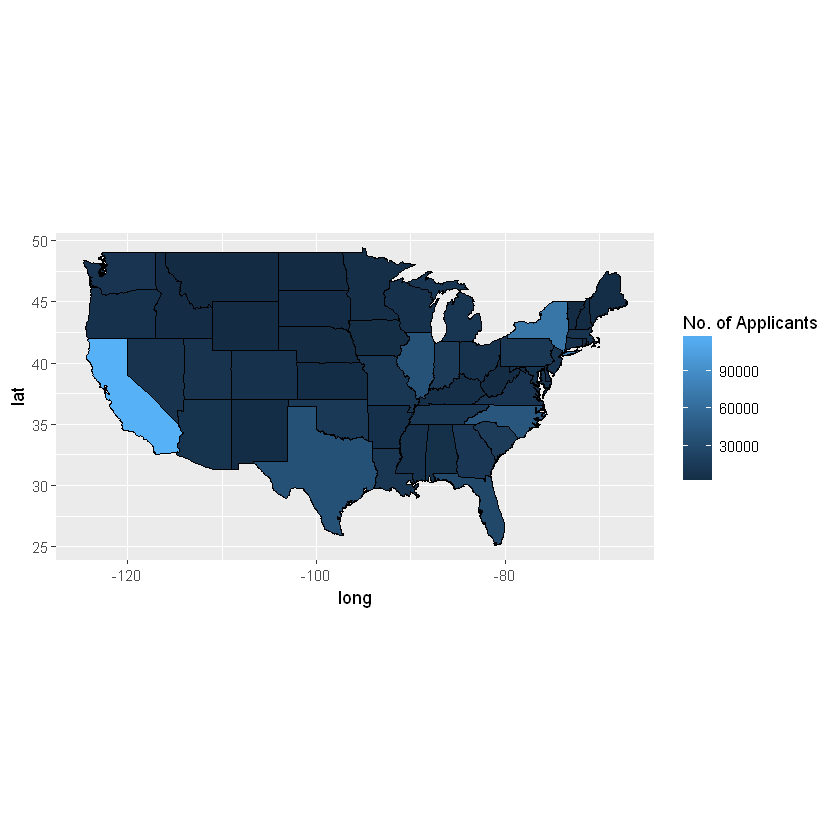

In [11]:
ggplot(data = mapd,mapping = aes(x = long, y = lat, group = group)) + 
  geom_polygon(color = "black", fill = "gray") + coord_fixed(1.3) +
  geom_polygon(data = mapd, aes(fill = `No. of Applicants`), color = "white") +
  geom_polygon(color = "black", fill = NA) 

### 2. Which states are more successful in having been identified as exciting projects
This is a little less surprising - NM, MD, MA, WI and CO - I wouldn't have guessed this - There's probably something to be learnt from these states' school administrations

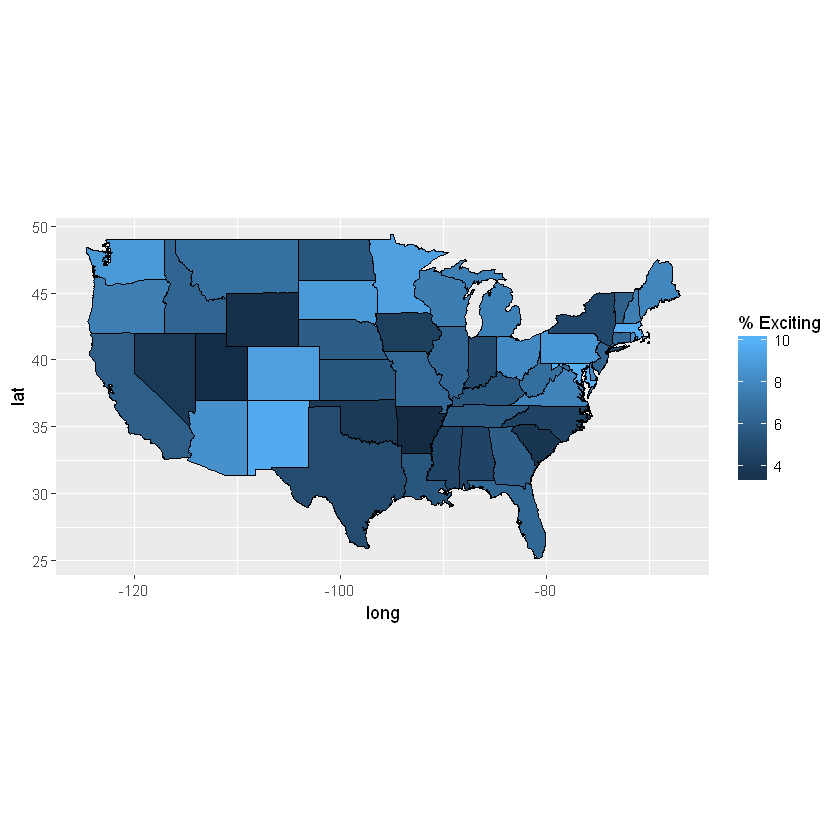

In [12]:
ggplot(data = mapd,mapping = aes(x = long, y = lat, group = group)) + 
  geom_polygon(color = "black", fill = "gray") + coord_fixed(1.3) +
  geom_polygon(data = mapd, aes(fill = `% Exciting`), color = "white") +
  geom_polygon(color = "black", fill = NA)

### 3. Which states receiving more donations per project
The west in general are receiving more donations per project - maybe they have better methods to be more appealing and better methods to reach to donors??

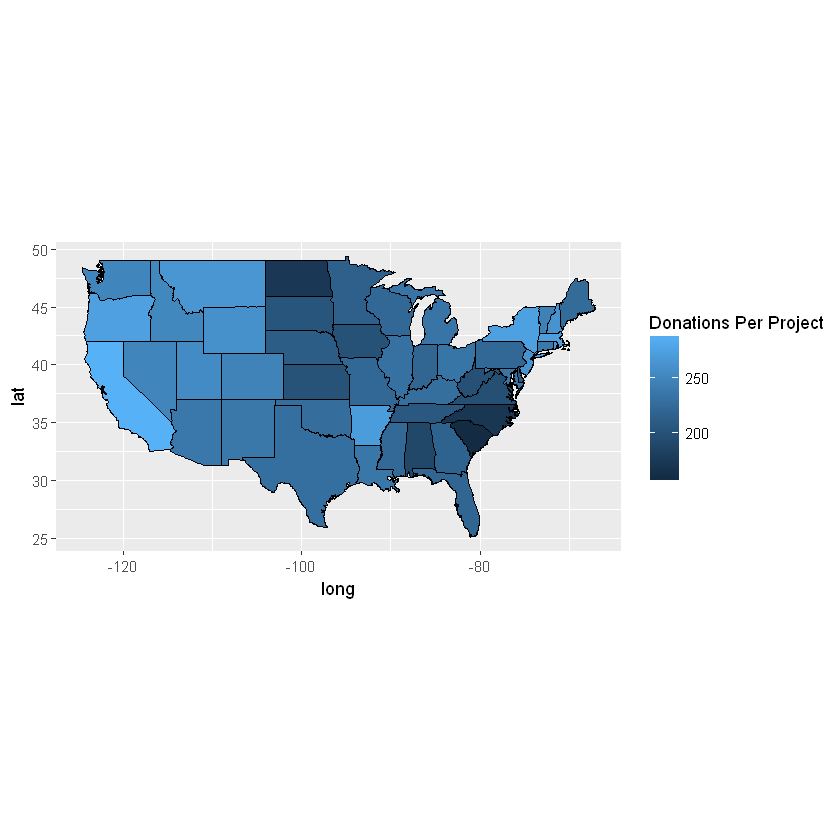

In [13]:
ggplot(data = mapd,mapping = aes(x = long, y = lat, group = group)) + 
  geom_polygon(color = "black", fill = "gray") + coord_fixed(1.3) +
  geom_polygon(data = mapd, aes(fill = `Donations Per Project`), color = "white") +
  geom_polygon(color = "black", fill = NA)

### 4. Wealthy (for lack of a better word) donors
AK is receiving more donations per project than average and AK donors donate more per project too! That's great. Maybe Walmart's philanthropic initiatives?

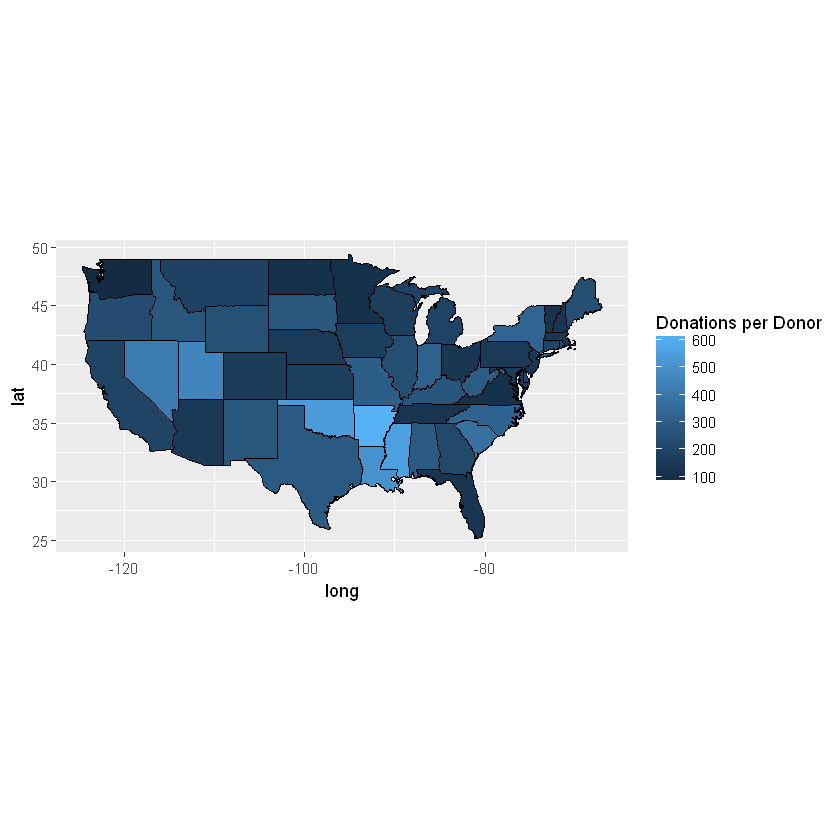

In [14]:
ggplot(data = mapd,mapping = aes(x = long, y = lat, group = group)) + 
  geom_polygon(color = "black", fill = "gray") + coord_fixed(1.3) +
  geom_polygon(data = mapd, aes(fill = `Donations per Donor`), color = "white") +
  geom_polygon(color = "black", fill = NA)

## B. TIMELINE WISE

In [34]:
#Some more data manipulations
projects$qtr <- paste(year(projects$date_posted),ifelse(month(projects$date_posted)<=3,'q1',
                                                        ifelse(month(projects$date_posted)<=6,'q2',
                                                               ifelse(month(projects$date_posted)<=9,'q3','q4'))),sep='')
projects$condition5 <- ifelse(projects$three_or_more_non_teacher_referred_donors=='t'|
                                projects$one_non_teacher_referred_donor_giving_100_plus=='t'|
                                projects$donation_from_thoughtful_donor=='t','t','f')
b <- donations %>% group_by(projectid) %>% summarise(donation_total = sum(donation_total,na.rm=T))
projects$donation_total <- b$donation_total[match(projects$projectid,b$projectid)]
projects$donation_total[which(projects$eligible_double_your_impact_match=='t')] <- projects$donation_total[which(projects$eligible_double_your_impact_match=='t')] *2
projects$donation_total[which(projects$eligible_almost_home_match=='t')] <- projects$donation_total[which(projects$eligible_almost_home_match=='t')] + 100 
a <- projects[projects$train==1,] %>% group_by(qtr) %>% summarise(n=n(),
                                                                  nexciting = length(which(is_exciting=='t')),
                                                                  nfullyfunded=length(which(fully_funded=='t')),
                                                                  nat_least_1_teacher_referred_donor = length(which(at_least_1_teacher_referred_donor=='t')),
                                                                  ngreat_chat = length(which(great_chat=='t')),
                                                                  nat_least_1_green_donation = length(which(at_least_1_green_donation=='t')),
                                                                  ncondition5 = length(which(condition5=='t')),
                                                                  nallconditions = length(which(fully_funded=='t'&at_least_1_teacher_referred_donor=='t'&great_chat=='t'&at_least_1_green_donation=='t'&condition5=='t')),
                                                                  avg_proj_price = mean(total_price_including_optional_support,na.rm=T),
                                                                  donation_total = sum(donation_total,na.rm=T)
                                                                  )

donations$projqtr <- projects$qtr[match(donations$projectid,projects$projectid)]
b <- donations %>% group_by(projqtr) %>% summarise(no_donations = n(),
                                                   #donation_amt = sum(donation_total,na.rm=T),
                                                   nprojects = length(unique(projectid)),
                                                   donation_by_teacher = sum(donation_total[which(is_teacher_acct=='t')],na.rm=T),
                                                   nprojects_teacher_donation=length(unique(projectid[which(is_teacher_acct=='t')])))
a[,names(b)[2:ncol(b)]] <- b[match(a$qtr,b$projqtr),names(b)[2:ncol(b)]]
a$nstudents_impact <- sapply(a$qtr,function(x)sum(projects$students_reached[which(projects$qtr==x&projects$fully_funded=='t')],na.rm=T))


![Metrics](Capture.png)

We can see that the number of project applications and the number of students impacted are constantly on the rise which is a good thing. There seems to be a seasonal decrease in the number of projects posted in Q1, Q2 and a seasonal increase in the number of projects posted in Q3, Q4 of every year.

Among the projects submitted and the 5 satisfactory requirements in place (for exciting projects), being fully funded, at_least_1_green_donation and satisfying condition #5 (three_or_more_non_teacher_referred_donors, one_non_teacher_referred_donor_giving_100_plus, donation_from_thoughtful_donor) seems to be the easiest to achieve. What projects fail more to achieve are great_chat and the worst - at_least_1_teacher_referred_donor) - The organization should let students and teachers know of this so they can concentrate more in having a great_chat and at_least_1_teacher_referred_donor

![Metrics](Capture2.png)

It seems that since 2010, the average price of a project meets the average donation made to a project (for projects that received donation) - which is a good sign.

However, about 10% - 15% of all donations to a project are being made by teachers - Shoutout to them! What the US Department of Education must do is to promote this by matchings or recognitions.

## DATA STORY

Thus far, we have identifed a few things to pick the trail on:

    Case study on New Mexico K12 schools to find why they lead in having the highest percentage of exciting projects
    Case study on AK donors who donate the most per project and AK projects that receive more donations per project than average to find any good reasons
    Concentrating on having a great_chat and having at_least_1_teacher_referred_donor, so more projects can qualify for being exciting
    Govt. to help teachers who donate through matchings 
    

# MODEL

In the limited time available, I have developed a logistic regression model (which didn't turn out great - spoiler) to predict exciting projects. I have presented evaluation metrics for my model and also discussed how to make a better model

In [16]:
#dependent variable
projects$exciting <- ifelse(projects$is_exciting=='t',1,0)

NULL

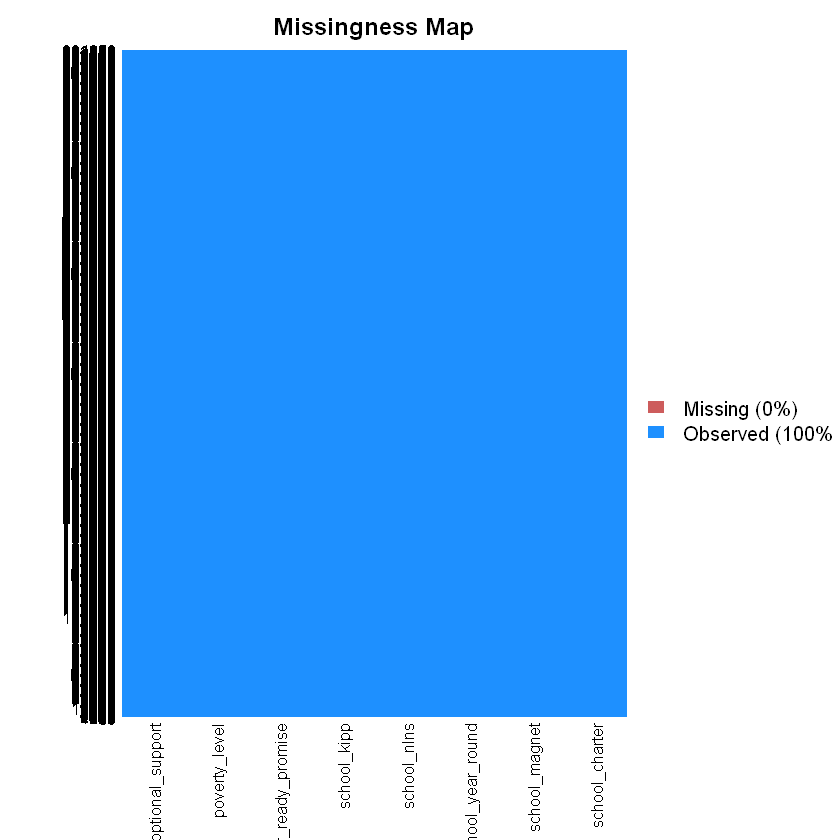

In [19]:
#missing data
msmap <- missmap(projects[,c('school_charter','school_magnet','school_year_round','school_nlns','school_kipp',
                                                                                       'school_charter_ready_promise','poverty_level',
                                                                                       'total_price_including_optional_support')])
msmap

In [18]:
#MODEL - I am using data only since 2010Q2
a <- which(projects$calper>=2010007 & projects$calper<=2013012)
tr <- sample(a,length(a)*0.8,replace = F)
val <- a[which(!(a %in% tr))]
logisticRegression <- glm(exciting ~ as.factor(school_charter) + as.factor(school_magnet)+
                            as.factor(school_year_round) + as.factor(school_nlns) + as.factor(school_kipp) + as.factor(school_charter_ready_promise)+
                            as.factor(poverty_level)  + total_price_including_optional_support  ,
                            data =projects[tr,], family = binomial(link='logit'),control = list(maxit = 1000))
summary(logisticRegression)


Call:
glm(formula = exciting ~ as.factor(school_charter) + as.factor(school_magnet) + 
    as.factor(school_year_round) + as.factor(school_nlns) + as.factor(school_kipp) + 
    as.factor(school_charter_ready_promise) + as.factor(poverty_level) + 
    total_price_including_optional_support, family = binomial(link = "logit"), 
    data = projects[tr, ], control = list(maxit = 1000))

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-0.6816  -0.4327  -0.4222  -0.4023   3.9631  

Coefficients:
                                           Estimate Std. Error  z value
(Intercept)                              -2.439e+00  1.437e-02 -169.808
as.factor(school_charter)t                4.517e-01  1.955e-02   23.103
as.factor(school_magnet)t                 1.246e-01  2.148e-02    5.800
as.factor(school_year_round)t            -1.159e-01  3.006e-02   -3.856
as.factor(school_nlns)t                   4.246e-01  4.573e-02    9.285
as.factor(school_kipp)t                   2.065e-01  5

Seems to me that school type and other school characteristics along with project attributes can make a good model with significant variables.

Interpretation Example - Log Odds of Chartered Schools is 0.45. Hence Odds = exp(0.45) = 1.56. A Project from a chartered school is 1.56 times more probable to being an exciting project than a project from a non-chartered school 

### Model Evaluation

In [23]:
fitted.results_p <- predict(logisticRegression,newdata=projects[val,],type='response')
fitted.results <- ifelse(fitted.results_p > 0.1,1,0)
print(table(fitted.results,projects$exciting[val]))

              
fitted.results     0     1
             0 65996  6207
             1  8554  1238


It's a bad model - I agree. The model identified 1,238 correct exciting projects while it missed to identify 6,207 exciting projects

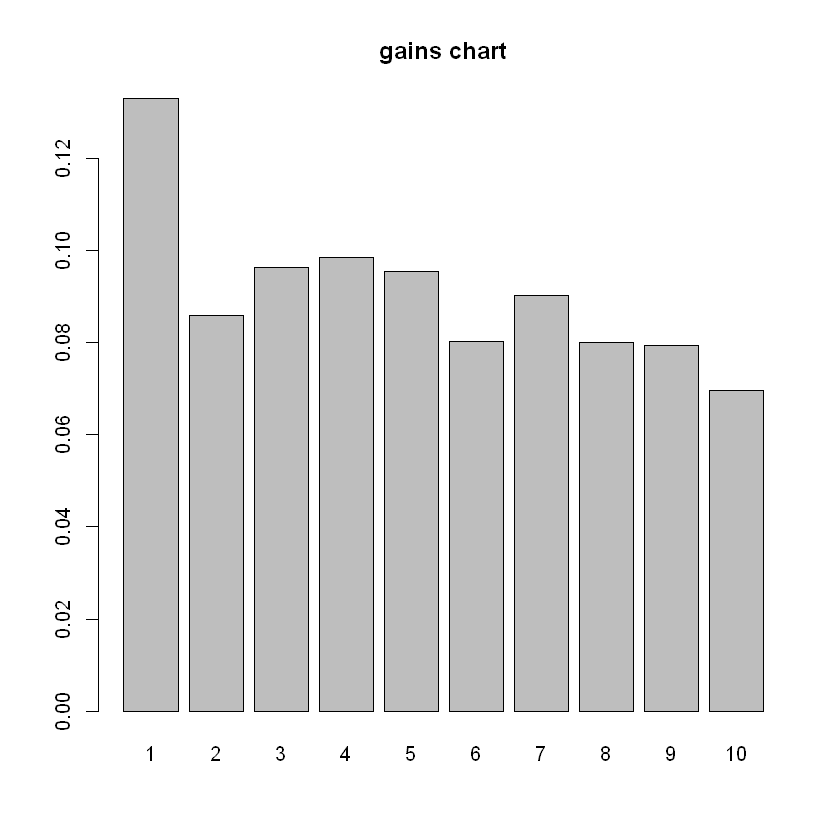

In [25]:
par(mfrow=c(1,1))
gain.chart(10,as.numeric(fitted.results_p),projects$exciting[val])

Again, we're not seeing a good negative slope in the gains chart - which means the model is not very powerful

[1] 0.5456952


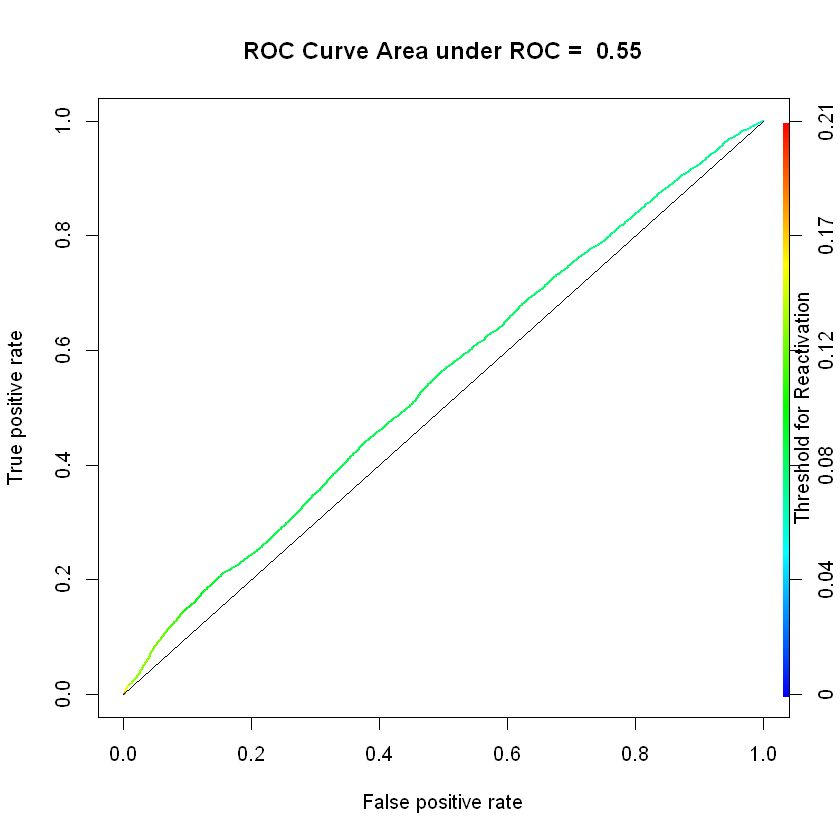

In [37]:
plo(fitted.results_p,projects$exciting[val])

The ROC curve doesn't look fantastic either

## Things to do for a better model - 

The model hasn't used all the information available. To start with, I haven't even touched the eaasys data that probably has some good predictive information - I can try and find correlations between main words being used in descriptions and essays and the project being an exciting project.

I can try and use gradient boosting models - like xgboost, etc.

There seems to be a class imbalance problem - Only 6% of all projects are exciting - This decreases the predictive power of the model. There are two solutions I can thik of : Do repetitive probabilistic sampling based on distribution of important variables - but this can lead to overfitting. The second is using the SMOTE algorithm - Synthetic Modified Oversampling Technique. There is even an xgboost implementation to this.

Try using neural netwoks or deep learning to use a combination of activation functions.